In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import os
# os.environ["QISKIT_IN_PARALLEL"] = 'TRUE'

In [3]:
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

plt.rcParams["font.size"] = 16

from qiskit import QuantumCircuit, IBMQ, schedule
import qiskit.pulse as pulse
from qiskit.quantum_info.states import Statevector, DensityMatrix
from qiskit_dynamics import Solver, Signal
from qiskit_dynamics.pulse import InstructionToSignals
from qiskit.providers import BackendV2, QubitProperties
from qiskit.providers.options import Options
from qiskit.transpiler import Target

from qiskit.providers.models import PulseDefaults
from qiskit.qobj.pulse_qobj import PulseLibraryItem, PulseQobjInstruction
from qiskit.providers.models.pulsedefaults import Command

from qiskit_experiments.exceptions import QiskitError

In [4]:
# IBMQ.load_account()
# provider = IBMQ.get_provider(hub="ibm-q", group="open", project="main")
# backend = provider.get_backend("ibmq_manila")

In [5]:
from qiskit_experiments.test.pulse_backend import SingleTransmonTestBackend, ParallelTransmonTestBackend
pulse_backend = ParallelTransmonTestBackend(noise=False) 
pulse_backend1 = SingleTransmonTestBackend(noise=False)

In [6]:
from qiskit_experiments.data_processing.discriminator import BaseDiscriminator

class FakeDiscriminator(BaseDiscriminator):
    """A fake discriminator class for testing."""

    def predict(self, data):
        """Discriminate the data"""
        return ["0" if iq[0] > iq[1] else "1" for iq in data]

    def config(self):
        """Config method."""
        return {}

    def is_trained(self):
        """This test discriminator is always trained."""
        return True

pulse_backend.discriminator = FakeDiscriminator()

In [7]:
import numpy as np

from qiskit_experiments.calibration_management.calibrations import Calibrations
from qiskit_experiments.calibration_management.basis_gate_library import (
    FixedFrequencyTransmon,
)
# from qiskit_experiments.test.pulse_backend import ParallelTransmonTestBackend, SingleTransmonTestBackend
# pulse_backend = ParallelTransmonTestBackend(noise=False)
# pulse_backend1 = SingleTransmonTestBackend(noise=False)
# qubit = 0
library = FixedFrequencyTransmon()
cals = Calibrations.from_backend(pulse_backend, libraries=[library])

In [8]:
# cals.add_parameter_value(320,'duration',(),schedule='x')

In [9]:
from qiskit_experiments.library.calibration import RoughXSXAmplitudeCal

rabi0 = RoughXSXAmplitudeCal(
    0, cals, backend=pulse_backend, amplitudes=np.linspace(-0.1, 0.1, 55)
)

rabi1 = RoughXSXAmplitudeCal(
    1, cals, backend=pulse_backend, amplitudes=np.linspace(-0.1, 0.1, 55)
)

In [10]:
from qiskit_experiments.framework.composite import ParallelExperiment

In [11]:
rabi_parallel = ParallelExperiment([rabi0,rabi1],backend=pulse_backend)

In [12]:
rabi_data = rabi_parallel.run(shots=4000, meas_level=2).block_for_results()

/home/rupeshknn/projects/qc/pulse-backend-qamp22/qiskit-experiments/qiskit_experiments/framework/composite/composite_experiment.py:168: UserWarning: Component 0 RoughXSXAmplitudeCal experiment run options ['meas_return'] values ['single'] will be overridden with ParallelExperiment values [None].
  warnings.warn(
/home/rupeshknn/projects/qc/pulse-backend-qamp22/qiskit-experiments/qiskit_experiments/framework/composite/composite_experiment.py:168: UserWarning: Component 1 RoughXSXAmplitudeCal experiment run options ['meas_return'] values ['single'] will be overridden with ParallelExperiment values [None].
  warnings.warn(


Component experiment 0


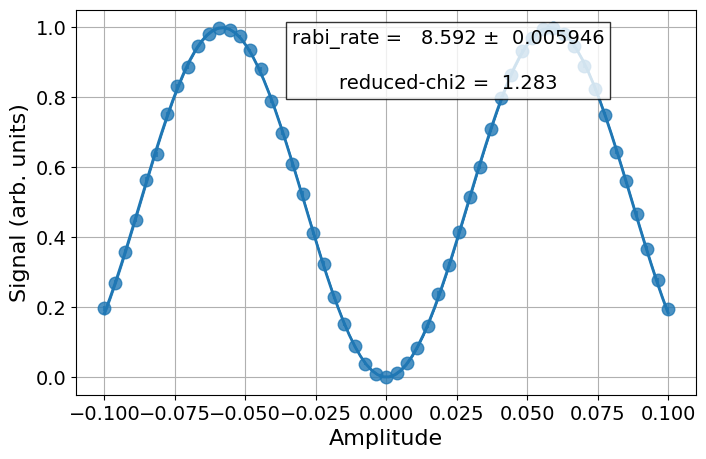

AnalysisResult
- name: @Parameters_OscillationAnalysis
- value: CurveFitResult:
 - fitting method: least_squares
 - number of sub-models: 1
  * F_cos(x) = amp * cos(2 * pi * freq * x + phase) + base
 - success: True
 - number of function evals: 18
 - degree of freedom: 51
 - chi-square: 65.44598123677065
 - reduced chi-square: 1.2832545340543264
 - Akaike info crit.: 17.564054676146633
 - Bayesian info crit.: 25.59338741707652
 - init params:
  * amp = 0.5105348662834291
  * freq = 9.820047627230998
  * phase = 1.5707963267948966
  * base = 0.5111597100724818
 - fit params:
  * amp = 0.4992235872203976 ± 0.0002609235664644312
  * freq = 8.591657512128295 ± 0.005945864153941635
  * phase = 3.139798706706712 ± 0.0021928437467453364
  * base = 0.4999630767976256 ± 0.00025535502411237044
 - correlations:
  * (freq, phase) = -0.006580364404142064
  * (amp, phase) = 0.010632060158250368
  * (amp, base) = 0.014389282753037741
  * (phase, base) = 0.021508302285470376
  * (amp, freq) = 0.054384

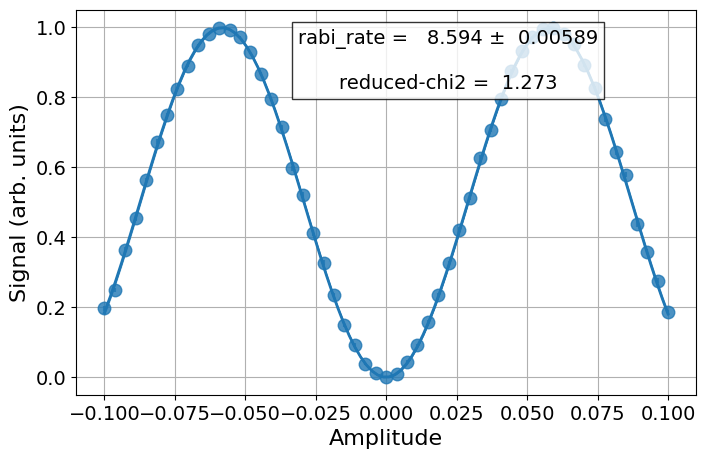

AnalysisResult
- name: @Parameters_OscillationAnalysis
- value: CurveFitResult:
 - fitting method: least_squares
 - number of sub-models: 1
  * F_cos(x) = amp * cos(2 * pi * freq * x + phase) + base
 - success: True
 - number of function evals: 10
 - degree of freedom: 51
 - chi-square: 64.93505834840522
 - reduced chi-square: 1.273236438204024
 - Akaike info crit.: 17.132996559253485
 - Bayesian info crit.: 25.162329300183373
 - init params:
  * amp = 0.5114346413396651
  * freq = 9.820047627230998
  * phase = 0.0
  * base = 0.5115596100974756
 - fit params:
  * amp = -0.4996011373902906 ± 0.00020835772244371246
  * freq = 8.594309331029084 ± 0.0058902464828198865
  * phase = 0.004111115897825379 ± 0.0021844468933526935
  * base = 0.4997773245961808 ± 0.00020661152112794716
 - correlations:
  * (amp, base) = -0.6504763469243203
  * (amp, freq) = -0.09261000465589916
  * (amp, phase) = -0.013433384138021587
  * (freq, phase) = -0.009276004813751015
  * (phase, base) = -0.00775614420208

In [13]:
for i, sub_data in enumerate(rabi_data.child_data()):
    print("Component experiment",i)
    display(sub_data.figure(0))
    for result in sub_data.analysis_results():
        print(result)